In [1]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net_heat = ContTempNetwork.load('fig3_growing_network300')


# Check communities

In [3]:
net_heat.times

Index([0.010867646069036493,  0.02386229589341664,   0.0631979478676564,
        0.12523586182299767,  0.14119738696878154,  0.15083594401388595,
        0.15501089547519584,  0.16781030719605725,  0.18363426112506734,
        0.21481689967112408,
       ...
          299.7109202035304,   299.73916894405454,   299.77177197047126,
          299.7846607036029,    299.7907768954225,    299.8163601897989,
          299.8354351430701,   299.87599949291973,    299.8904545086285,
          299.8905950166158],
      dtype='float64', name='times', length=18596)

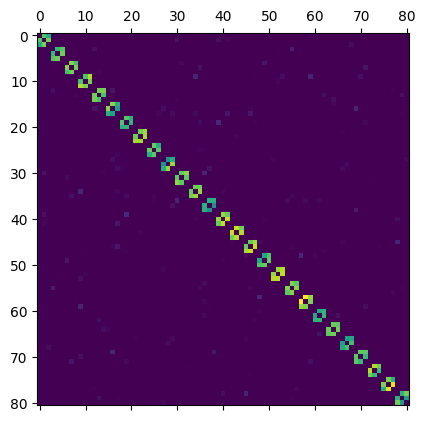

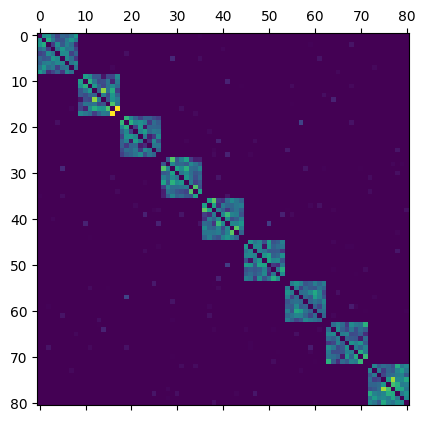

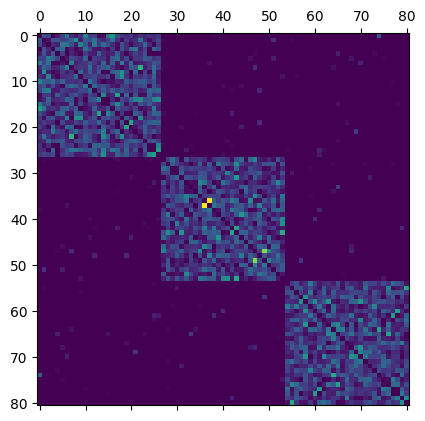

In [4]:
plt.matshow(net_heat.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray())
plt.matshow(net_heat.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray())
plt.matshow(net_heat.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray())


In [5]:
lamdas_explore = np.logspace(-7,7,50)

In [6]:
multi_res_heat = {}
for lamda in lamdas_explore:
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/clustersexplore/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_explore]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_explore]

In [7]:
lamdas_explore

array([1.00000000e-07, 1.93069773e-07, 3.72759372e-07, 7.19685673e-07,
       1.38949549e-06, 2.68269580e-06, 5.17947468e-06, 1.00000000e-05,
       1.93069773e-05, 3.72759372e-05, 7.19685673e-05, 1.38949549e-04,
       2.68269580e-04, 5.17947468e-04, 1.00000000e-03, 1.93069773e-03,
       3.72759372e-03, 7.19685673e-03, 1.38949549e-02, 2.68269580e-02,
       5.17947468e-02, 1.00000000e-01, 1.93069773e-01, 3.72759372e-01,
       7.19685673e-01, 1.38949549e+00, 2.68269580e+00, 5.17947468e+00,
       1.00000000e+01, 1.93069773e+01, 3.72759372e+01, 7.19685673e+01,
       1.38949549e+02, 2.68269580e+02, 5.17947468e+02, 1.00000000e+03,
       1.93069773e+03, 3.72759372e+03, 7.19685673e+03, 1.38949549e+04,
       2.68269580e+04, 5.17947468e+04, 1.00000000e+05, 1.93069773e+05,
       3.72759372e+05, 7.19685673e+05, 1.38949549e+06, 2.68269580e+06,
       5.17947468e+06, 1.00000000e+07])

In [8]:
print(avg_nclusters_forw_heat)

[81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 68.89, 29.02, 10.9, 5.74, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


In [9]:
print(NVI_forw_heat)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001061004827601376, 0.01091293838768648, 0.0029261624458873487, 0.020168521272005215, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


we will study lamdas within the range (10e-5, 10e-1)

# Derivative

In [10]:
lamdas_shrinking = np.logspace(-3.5,-2,200)

In [11]:
multi_res_heat = {}
for lamda in lamdas_shrinking:
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_shrinking]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_shrinking]

In [12]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [13]:
lamdas_vNS =  np.logspace(-3,1,200)

vNS_heat_end = []
for i, lamda in enumerate(lamdas_vNS):
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end.append(S[list(S.keys())[0]][0])

In [14]:
v1 = vNS_heat_end
v2 = between_lamdas =  np.linspace(-3,1,200)
ds_dt = derivative(v1, v2)

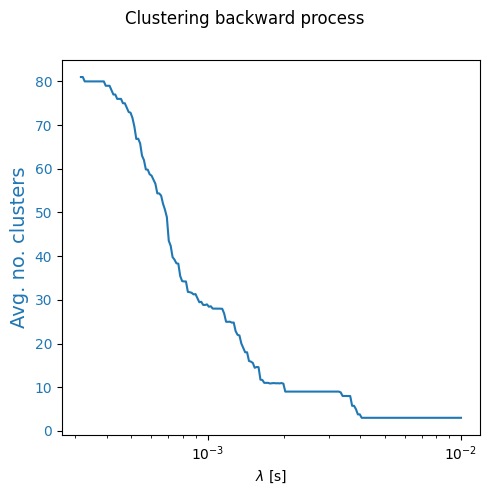

In [16]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(5, 5))

####### First Plot
color = 'tab:blue'
axs.plot(lamdas_shrinking, avg_nclusters_forw_heat, color=color)

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. no. clusters', color=color, fontsize = 14)
axs.tick_params(axis='y', labelcolor=color)

# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

fig.suptitle('Clustering backward process')
#plt.savefig('/home/b/skoove/Desktop/growing300/backward_clusters.png', format='png', dpi=600)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


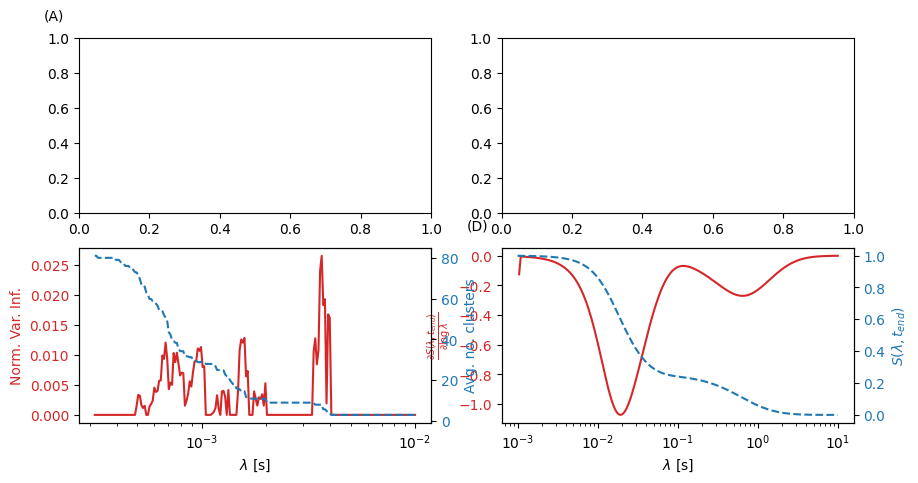

In [15]:
fig, axs = plt.subplots(2,2, sharex=False, figsize=(10, 5))
####### First Plot
color = 'tab:red'
axs[1,0].plot(lamdas_shrinking, NVI_forw_heat, color=color, label='static norm NVI')

axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$\lambda$ [s]')
axs[1,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[1,0].tick_params(axis='y', labelcolor=color)
axs[1,0].text(-0.1,1.1, '(A)', transform=axs[0,0].transAxes)

ax1 = axs[1,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_shrinking, avg_nclusters_forw_heat, '--', color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axs[1,1].plot(lamdas_vNS[1:], ds_dt, color=color, label='dvNSdt')

axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$\lambda$ [s]')

axs[1,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1,1].tick_params(axis='y', labelcolor=color)
axs[1,1].text(-0.1,1.1, '(D)', transform=axs[1,1].transAxes)

ax4 = axs[1,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_heat_end, '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)

# Last Plot

In [16]:
selected_lamdas = np.logspace(-3,1,10)
sample_times = list(np.arange(0, len(net_heat.times), 10))

In [17]:
vNS_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/vNS_selected/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        vNS_selected.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


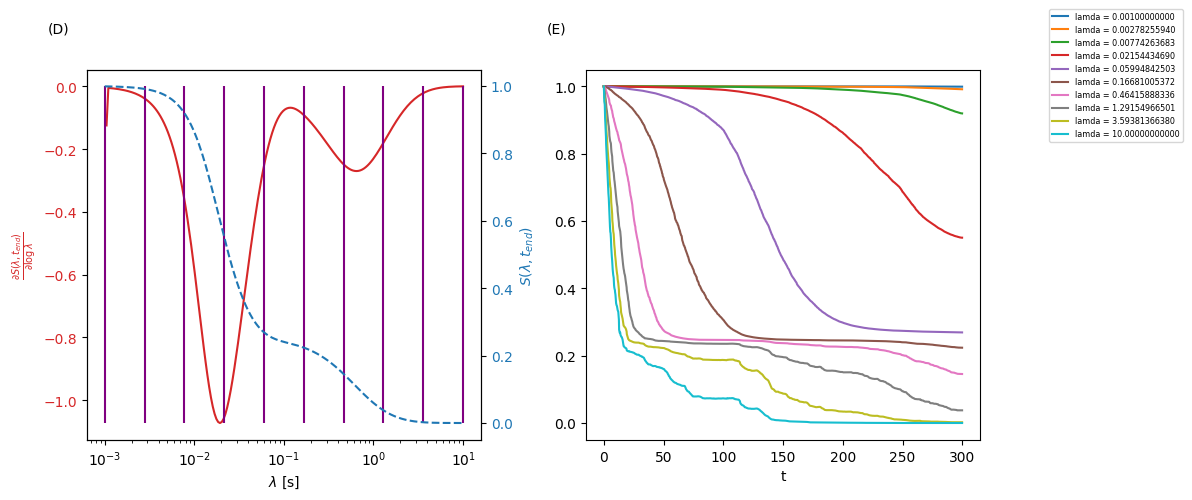

In [18]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))


####### Fourth Plot

color = 'tab:red'
axs[0].plot(lamdas_vNS[1:], ds_dt, color=color)

axs[0].set_xscale('log')
axs[0].set_xlabel(r'$\lambda$ [s]')

axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

min_ds7dt = np.min(ds_dt)
max_ds7dt = np.max(ds_dt)


axs[0].vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt], ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt], colors='purple')

ax1 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_vNS, vNS_heat_end, '--', color=color)

ax1.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

#Plot 5

for i, lamda in enumerate(selected_lamdas):
    axs[1].plot(net_heat.times[sample_times], vNS_selected[i], label='lamda = ' + f'{lamda:.11f}')
    axs[1].set_xlabel('t')
axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)


fig.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/plots250/choice_selected_lamdas.eps', format='eps')
plt.show()

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotx/_optimize.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  s[mask] = numpy.linalg.lstsq(AtA[mask][:, mask], Atb[mask], rcond=None)[0]
/tmp/ipykernel_1093072/2783061837.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


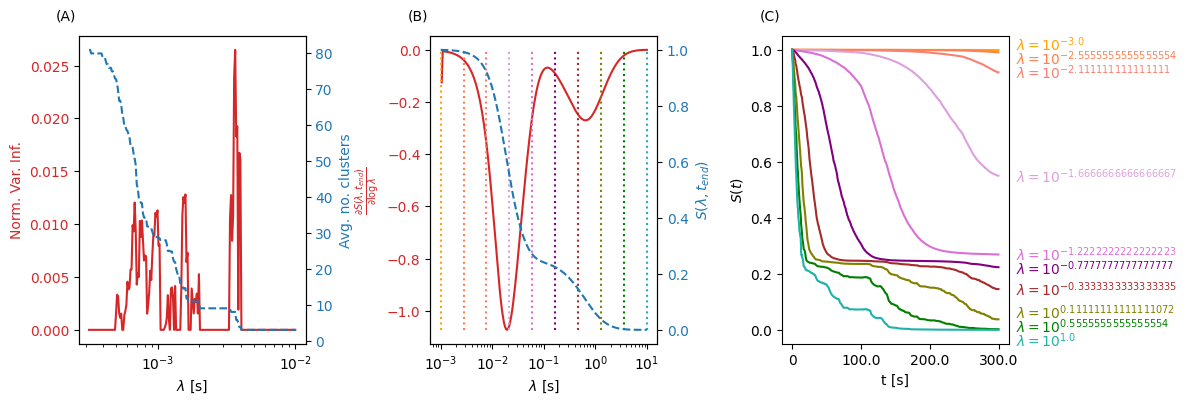

In [19]:
# Create a 2x3 grid of subplots with specific figure size
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.55)


####### Third Plot
color = 'tab:red'
axsc = plt.subplot(gs[0,0])
axsc.plot(lamdas_shrinking, NVI_forw_heat, color=color)

axsc.set_xscale('log')
axsc.set_xlabel(r'$\lambda$ [s]')
axsc.set_ylabel('Norm. Var. Inf.', color=color)
axsc.tick_params(axis='y', labelcolor=color)
axsc.text(-0.1,1.05, '(A)', transform=axsc.transAxes)

ax3 = axsc.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_shrinking, avg_nclusters_forw_heat, '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axsd = plt.subplot(gs[0,1])
axsd.plot(lamdas_vNS[1:], ds_dt, color=color, label='dvNSdt')

axsd.set_xscale('log')
axsd.set_xlabel(r'$\lambda$ [s]')

axsd.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axsd.tick_params(axis='y', labelcolor=color)
axsd.text(-0.1,1.05, '(B)', transform=axsd.transAxes)

min_ds7dt = np.min(ds_dt)
max_ds7dt = np.max(ds_dt)
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
axsd.vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt],
            ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt],
            colors= list_colors, linestyles='dotted')

ax4 = axsd.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_heat_end, '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)


#Plot 5
list_annotate_y = []
for i, lamda in enumerate(selected_lamdas):
    list_annotate_y.append(np.mean(vNS_selected[i]))

shift_annotate_y = [0.01, 0.03, 0.02, -0.05, -0.4, -0.35, -0.05, -0.05, -0.06]

axse = plt.subplot(gs[0,2])
for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-3,1,10)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    axse.plot(net_heat.times[sample_times], vNS_selected[i], color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)
    axse.set_xlabel('t [s]')
    #axse.annotate(text = r'$\lambda = e^{%s}$' % exponent, xy=[100, list_annotate_y[i]], xytext=[105, list_annotate_y[i]+shift_annotate_y[1]-0.05], color='magenta')
axse.text(-0.1,1.05, '(C)', transform=axse.transAxes)
axse.set_ylabel(r'$S(t)$')
matplotx.line_labels()
#axse.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1))


deltat1 = 300 / 3
# axse.vlines(x = [0.5*deltat1, 2*deltat1, 3.9*deltat1],
#             ymin = [np.min(vNS_heat0_50), np.min(vNS_heat0_50), np.min(vNS_heat0_50)], ymax = [np.max(vNS_heat0_50), np.max(vNS_heat0_50), np.max(vNS_heat0_50)], colors='purple')
plt.xticks([0, deltat1, 2*deltat1, 3*deltat1,],[0, str(deltat1), str(2*deltat1), str(3*deltat1)])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/plots250/figNetSci_rev.eps', format='eps', dpi=300)
plt.show()

# Entropy Rate

In [20]:
S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/S_rate_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

/tmp/ipykernel_1093072/2306398984.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


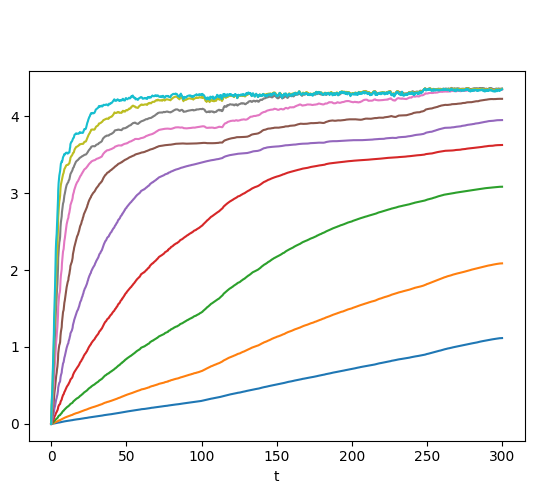

In [21]:
#Plot 5

for i, lamda in enumerate(selected_lamdas):
    plt.plot(net_heat.times[sample_times], S_rate_selected[i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')
plt.text(-0.1,1.1, '(E)', transform=axs[1].transAxes)


fig.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/plots250/choice_selected_lamdas.eps', format='eps')
plt.show()

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotx/_optimize.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  s[mask] = numpy.linalg.lstsq(AtA[mask][:, mask], Atb[mask], rcond=None)[0]
/tmp/ipykernel_1093072/3331189998.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/text.py:754: ComplexWarning: Casting 

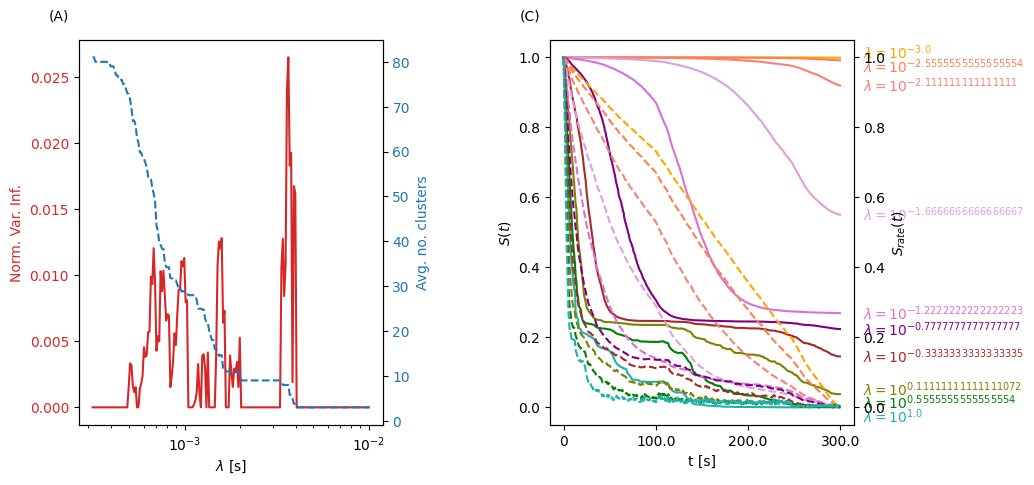

In [22]:
# Create a 2x3 grid of subplots with specific figure size
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.55)


####### Third Plot
color = 'tab:red'
axsc = plt.subplot(gs[0,0])
axsc.plot(lamdas_shrinking, NVI_forw_heat, color=color)

axsc.set_xscale('log')
axsc.set_xlabel(r'$\lambda$ [s]')
axsc.set_ylabel('Norm. Var. Inf.', color=color)
axsc.tick_params(axis='y', labelcolor=color)
axsc.text(-0.1,1.05, '(A)', transform=axsc.transAxes)

ax3 = axsc.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_shrinking, avg_nclusters_forw_heat, '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)




#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

list_annotate_y = []
for i, lamda in enumerate(selected_lamdas):
    list_annotate_y.append(np.mean(vNS_selected[i]))

shift_annotate_y = [0.01, 0.03, 0.02, -0.05, -0.4, -0.35, -0.05, -0.05, -0.06]

axse = plt.subplot(gs[0,1])
for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-3,1,10)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    axse.plot(net_heat.times[sample_times], vNS_selected[i], color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)
    axse.set_xlabel('t [s]')
    #axse.annotate(text = r'$\lambda = e^{%s}$' % exponent, xy=[100, list_annotate_y[i]], xytext=[105, list_annotate_y[i]+shift_annotate_y[1]-0.05], color='magenta')
axse.text(-0.1,1.05, '(C)', transform=axse.transAxes)
axse.set_ylabel(r'$S(t)$')
matplotx.line_labels()
#axse.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1))

ax6 = axse.twinx()  # instantiate a second axes that shares the same x-axis


for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-3,1,10)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    ax6.plot(net_heat.times[sample_times], 1- (S_rate_selected[i] / max(S_rate_selected[i])), '--', color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)

ax6.set_ylabel(r'$S_{rate}(t)$')

deltat1 = 300 / 3
# axse.vlines(x = [0.5*deltat1, 2*deltat1, 3.9*deltat1],
#             ymin = [np.min(vNS_heat0_50), np.min(vNS_heat0_50), np.min(vNS_heat0_50)], ymax = [np.max(vNS_heat0_50), np.max(vNS_heat0_50), np.max(vNS_heat0_50)], colors='purple')
plt.xticks([0, deltat1, 2*deltat1, 3*deltat1,],[0, str(deltat1), str(2*deltat1), str(3*deltat1)])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/plots250/figNetSci_rev.eps', format='eps', dpi=300)
plt.show()

In [23]:
instantaneous_S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/shrinking_experiment300_temporal_heat/instantaneous_S_rate_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        instantaneous_S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

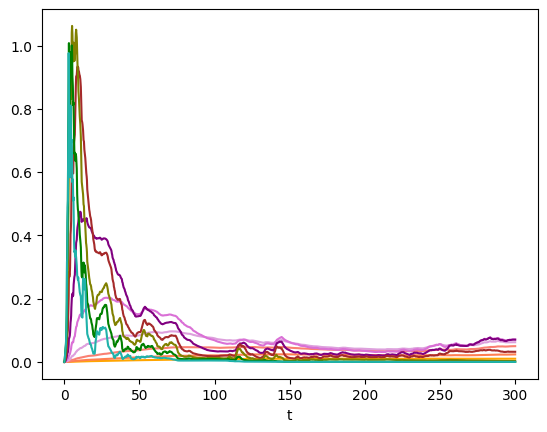

In [24]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']


for i, lamda in enumerate(selected_lamdas):
    plt.plot(net_heat.times[sample_times], instantaneous_S_rate_selected[i], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


fig.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

#plt.savefig('/home/b/skoove/Desktop/plots250/choice_selected_lamdas.eps', format='eps')
plt.show()